
# 🧪 Swarm Consensus Simulation Using CTMC and CRN (Cross-Inhibition)

This notebook implements a **stochastic simulation** of a **Chemical Reaction Network (CRN)** model for swarm consensus using the **Gillespie algorithm (CTMC)**.

It uses the **cross-inhibition model** with **zealot agents**, as specified in the provided project definition.

## 📋 Project Setup

- Initial population: `X = 40`, `Y = 40`, `U = 20`
- Zealots: `ZX = 10`, `ZY = 10`
- Total agents: `N = 100`
- Reaction rates: `qx = 1.0`, `qy = 1.0`
- Time bound `t = 35`, persistence bound `h = 40`
- Majority threshold `m = 50` (% of population)
- Opinion gap `d = 10`

---
Due to the fact that we observed interesting differences when running experiments with regard to this factor, we will perform 2 runs in the experiments:
- one with "internal" zealots: the zealots make up a proportion of the population of X and Y, respectively.  
- one with "external" zealots: the population is only composed of X + Y + U,  and zealots are "outside" of it. This seems to not influence robust consensus as much as the first case.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")


## ⚙️ Gillespie CTMC Simulation for CRN

In [ ]:
def get_reaction_rates(X, Y, U, ZX, ZY, N, qx=1.0, qy=1.0):
    """Returns the propensity rates for each reaction"""
    return [
        qx * X * Y / N,        # 0: X + Y → X + U
        qy * X * Y / N,        # 1: X + Y → U + Y
        qx * X * U / N,        # 2: X + U → X + X
        qy * Y * U / N,        # 3: Y + U → Y + Y
        qy * X * ZY / N,       # 4: X + ZY → U + ZY
        qy * U * ZY / N,       # 5: U + ZY → Y + ZY
        qx * Y * ZX / N,       # 6: Y + ZX → U + ZX
        qx * U * ZX / N        # 7: U + ZX → X + ZX
    ]

def gillespie_simulation(initial_state, ZX, ZY, N, T_max=100, qx=1.0, qy=1.0):
    """Simulates the cross-inhibition CRN using Gillespie algorithm"""
    X, Y, U = initial_state
    t = 0
    history = [(t, X, Y, U)]

    while t < T_max:
        rates = get_reaction_rates(X, Y, U, ZX, ZY, N, qx, qy)
        total_rate = sum(rates)
        if total_rate <= 0:
            break

        dt = np.random.exponential(1 / total_rate)
        t += dt
        r = np.random.rand() * total_rate

        cumulative = 0
        for i, rate in enumerate(rates):
            cumulative += rate
            if r < cumulative:
                reaction = i
                break

        # Perform state update based on selected reaction
        if reaction == 0:      # X + Y → X + U
            Y -= 1
            U += 1
        elif reaction == 1:    # X + Y → U + Y
            X -= 1
            U += 1
        elif reaction == 2:    # X + U → X + X
            U -= 1
            X += 1
        elif reaction == 3:    # Y + U → Y + Y
            U -= 1
            Y += 1
        elif reaction == 4:    # X + ZY → U + ZY
            X -= 1
            U += 1
        elif reaction == 5:    # U + ZY → Y + ZY
            U -= 1
            Y += 1
        elif reaction == 6:    # Y + ZX → U + ZX
            Y -= 1
            U += 1
        elif reaction == 7:    # U + ZX → X + ZX
            U -= 1
            X += 1

        # Ensure no negative populations
        X, Y, U = max(0, X), max(0, Y), max(0, U)
        history.append((t, X, Y, U))

    return np.array(history)



## ✅ Consensus Property Checker (BLTL)

In [ ]:

def check_consensus_property(trajectory, ZX, ZY, m=50, d=10, t=35, h=40):
    times = trajectory[:, 0]
    min_m = (m / 100) * N # 50% of total N=100
    t_idx = np.where(times <= t)[0]
    if len(t_idx) == 0:
        return False
    for idx in t_idx:
        t_start = times[idx]
        X, Y, U = trajectory[idx, 1:4]
        total_time = 0
        for j in range(idx, len(trajectory) - 1):
            Xj, Yj, _ = trajectory[j, 1:4]
            dt = trajectory[j+1, 0] - trajectory[j, 0]
            cond_X = (Xj + ZX > min_m) and ((Xj - Yj) > d)
            cond_Y = (Yj + ZY > m) and ((Yj - Xj) > d)
            if cond_X or cond_Y:
                total_time += dt
                if total_time >= h:
                    return True
            else:
                break
    return False


# Experiments with "EXTERNAL" zealots

## 🎯 Objective 1: Consensus Probability from Default Initial State



In [ ]:
ZX = ZY = 10
N = 100
initial_state = [40, 40, 20]

num_repetitions = 5  # Define the number of times to repeat the simulation
samples_per_run = 10 # Define the number of samples per run

all_probabilities = [] # List to store consensus probabilities from each repetition

print(f"Running {num_repetitions} repetitions with {samples_per_run} samples each.")

for rep in range(num_repetitions):
    success = 0
    print(f"\n--- Repetition {rep + 1}/{num_repetitions} ---")
    for i in range(samples_per_run):
        traj = gillespie_simulation(initial_state, ZX, ZY, N)
        satisfied = check_consensus_property(traj, ZX, ZY)
        if satisfied:
            success += 1
        print(f"  Sample {i+1}/{samples_per_run} → {'✔ Consensus' if satisfied else '✘ No consensus'}")

    final_consensus_probability = success / samples_per_run
    all_probabilities.append(final_consensus_probability)
    print(f"  Consensus Probability for Repetition {rep + 1}: {final_consensus_probability:.3f}")

average_consensus_probability = np.mean(all_probabilities)
print(f"\nAverage Consensus Probability over {num_repetitions} repetitions: {average_consensus_probability:.3f}")

# Combine initial_state and average_consensus_probability into a single row
data_to_save = np.asarray([initial_state + [average_consensus_probability]])
np.savetxt("objective1_external_averaged.csv", data_to_save, delimiter=",")

Running 5 repetitions with 10 samples each.

--- Repetition 1/5 ---
  Sample 1/10 → ✔ Consensus
  Sample 2/10 → ✔ Consensus
  Sample 3/10 → ✔ Consensus
  Sample 4/10 → ✔ Consensus
  Sample 5/10 → ✔ Consensus
  Sample 6/10 → ✔ Consensus
  Sample 7/10 → ✔ Consensus
  Sample 8/10 → ✔ Consensus
  Sample 9/10 → ✔ Consensus
  Sample 10/10 → ✔ Consensus
  Consensus Probability for Repetition 1: 1.000

--- Repetition 2/5 ---
  Sample 1/10 → ✔ Consensus
  Sample 2/10 → ✔ Consensus
  Sample 3/10 → ✔ Consensus
  Sample 4/10 → ✔ Consensus
  Sample 5/10 → ✔ Consensus
  Sample 6/10 → ✔ Consensus
  Sample 7/10 → ✔ Consensus
  Sample 8/10 → ✔ Consensus
  Sample 9/10 → ✔ Consensus
  Sample 10/10 → ✔ Consensus
  Consensus Probability for Repetition 2: 1.000

--- Repetition 3/5 ---
  Sample 1/10 → ✔ Consensus
  Sample 2/10 → ✔ Consensus
  Sample 3/10 → ✔ Consensus
  Sample 4/10 → ✔ Consensus
  Sample 5/10 → ✔ Consensus
  Sample 6/10 → ✔ Consensus
  Sample 7/10 → ✔ Consensus
  Sample 8/10 → ✔ Consensus
  

## 🔁 Objective 2: Varying Zealots ZX = ZY

Running 5 repetitions with 10 samples each for varying zealots.

--- Zealot count: ZX = ZY = 5 ---
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5
    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for 5 zealots over 5 repetitions: 1.000

--- Zealot count: ZX = ZY = 10 ---
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5
    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for 10 zealots over 5 repetitions: 1.000

--- Zealot count: ZX = ZY = 15 ---
  Repetiti

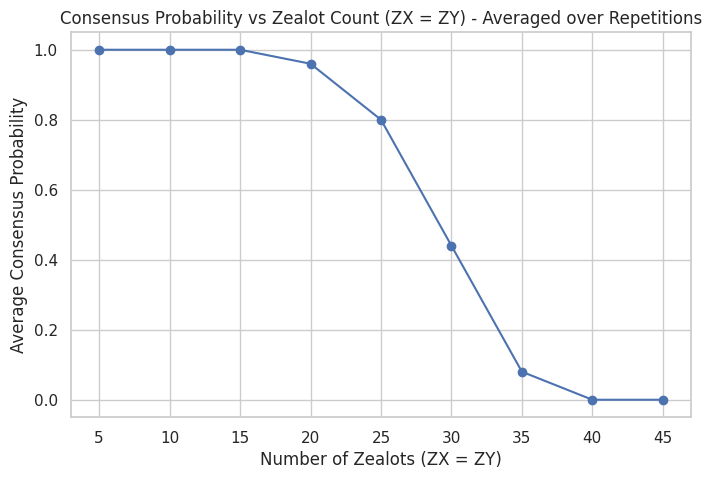

In [ ]:
zealot_range = [5, 10, 15, 20, 25, 30, 35, 40, 45]
results = []
num_repetitions = 5 # Number of repetitions
samples_per_run = 10 # Samples per run
N = 100
initial_state = [40, 40, 20]

print(f"Running {num_repetitions} repetitions with {samples_per_run} samples each for varying zealots.")

for z in zealot_range:
    all_probabilities = []
    print(f"\n--- Zealot count: ZX = ZY = {z} ---")
    for rep in range(num_repetitions):
        success = 0
        print(f"  Repetition {rep + 1}/{num_repetitions}")
        for i in range(samples_per_run):
            traj = gillespie_simulation(initial_state, z, z, N)
            satisfied = check_consensus_property(traj, z, z)
            if satisfied:
                success += 1
            # print(f"    Sample {i+1}/{samples_per_run} → {'✔ Consensus' if satisfied else '✘ No consensus'}") # Optional: uncomment to see individual sample results
        probability = success / samples_per_run
        all_probabilities.append(probability)
        print(f"    Consensus Probability for Repetition {rep + 1}: {probability:.3f}")

    average_probability = np.mean(all_probabilities)
    results.append(average_probability)
    print(f"  → Average Consensus probability for {z} zealots over {num_repetitions} repetitions: {average_probability:.3f}")


# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(zealot_range, results, marker='o')
plt.title("Consensus Probability vs Zealot Count (ZX = ZY) - Averaged over Repetitions")
plt.xlabel("Number of Zealots (ZX = ZY)")
plt.ylabel("Average Consensus Probability")
plt.grid(True)
plt.show()
plt.save("varying_zealots_plot.png")


# Save results as CSV
# Transpose the data for saving as columns: Zealot Count | Average Probability
data_to_save = np.asarray([zealot_range, results]).T
np.savetxt("objective2_external_averaged.csv", data_to_save, delimiter=",", header="Zealot_Count,Average_Probability", comments="")

## 📈 Objective 3: Varying Group Size N

Running 5 repetitions with 10 samples each for varying group sizes.


Group Size Loop:   0%|          | 0/5 [00:00<?, ?it/s]


--- Group Size N = 50 ---
  Zealots: ZX = ZY = 5
  Initial state: X = 25, Y = 25, U = 0
  Repetition 1/5
    Consensus Probability for Repetition 1: 0.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 0.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 0.000
  Repetition 4/5


Group Size Loop:  20%|██        | 1/5 [00:00<00:01,  2.58it/s]

    Consensus Probability for Repetition 4: 0.000
  Repetition 5/5
    Consensus Probability for Repetition 5: 0.000
  → Average Consensus probability for N=50 over 5 repetitions: 0.000

--- Group Size N = 75 ---
  Zealots: ZX = ZY = 7
  Initial state: X = 37, Y = 37, U = 1
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5


Group Size Loop:  40%|████      | 2/5 [00:00<00:01,  2.20it/s]

    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for N=75 over 5 repetitions: 1.000

--- Group Size N = 100 ---
  Zealots: ZX = ZY = 10
  Initial state: X = 50, Y = 50, U = 0
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5


Group Size Loop:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for N=100 over 5 repetitions: 1.000

--- Group Size N = 125 ---
  Zealots: ZX = ZY = 12
  Initial state: X = 62, Y = 62, U = 1
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5


Group Size Loop:  80%|████████  | 4/5 [00:03<00:01,  1.26s/it]

    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5
    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for N=125 over 5 repetitions: 1.000

--- Group Size N = 150 ---
  Zealots: ZX = ZY = 15
  Initial state: X = 75, Y = 75, U = 0
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5


Group Size Loop: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for N=150 over 5 repetitions: 1.000


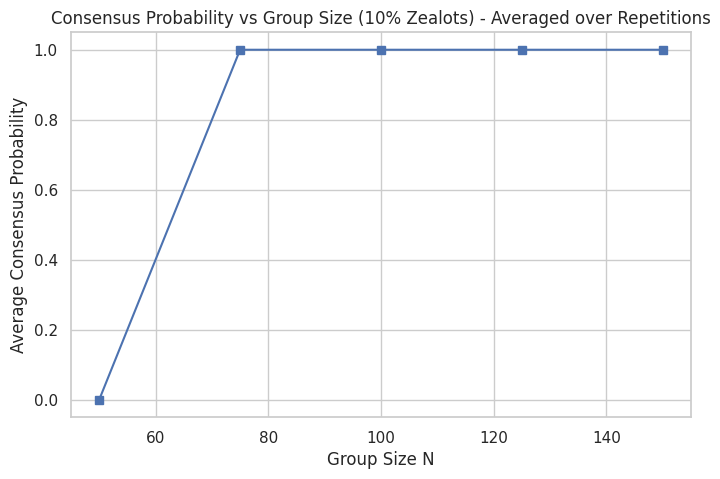

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Vary group size and zealot percentage
group_sizes = [50, 75, 100, 125, 150]
zealot_percent = 0.1
num_repetitions = 5 # Number of repetitions
samples_per_run = 10 # Samples per run
average_probs = []

print(f"Running {num_repetitions} repetitions with {samples_per_run} samples each for varying group sizes.")

for N_val in tqdm(group_sizes, desc="Group Size Loop"):
    zealots = int(zealot_percent * N_val)
    avail = N_val
    # Ensure initial state values are non-negative
    X0 = max(0, int(avail * 0.5))
    Y0 = max(0, int(avail * 0.5))
    U0 = max(0, avail - X0 - Y0)
    initial = [X0, Y0, U0]

    all_probabilities = []
    print(f"\n--- Group Size N = {N_val} ---")
    print(f"  Zealots: ZX = ZY = {zealots}")
    print(f"  Initial state: X = {X0}, Y = {Y0}, U = {U0}")

    for rep in range(num_repetitions):
        success = 0
        print(f"  Repetition {rep + 1}/{num_repetitions}")
        for i in range(samples_per_run):
            traj = gillespie_simulation(initial, zealots, zealots, N_val)
            satisfied = check_consensus_property(traj, zealots, zealots)
            if satisfied:
                success += 1
            # print(f"    Sample {i+1}/{samples_per_run} → {'✔ Consensus' if satisfied else '✘ No consensus'}") # Optional: uncomment to see individual sample results

        probability = success / samples_per_run
        all_probabilities.append(probability)
        print(f"    Consensus Probability for Repetition {rep + 1}: {probability:.3f}")

    average_probability = np.mean(all_probabilities)
    average_probs.append(average_probability)
    print(f"  → Average Consensus probability for N={N_val} over {num_repetitions} repetitions: {average_probability:.3f}")


# Plot results
plt.figure(figsize=(8, 5))
plt.plot(group_sizes, average_probs, marker='s')
plt.title("Consensus Probability vs Group Size (10% Zealots) - Averaged over Repetitions")
plt.xlabel("Group Size N")
plt.ylabel("Average Consensus Probability")
plt.grid(True)
plt.show()
plt.save("group_consensus_plot.png")

# Save results as CSV
data_to_save = np.asarray([group_sizes, average_probs]).T
np.savetxt("objective3_external_averaged.csv", data_to_save, delimiter=",", header="Group_Size,Average_Probability", comments="")

# Experiments with "INTERNAL" zealots.
The different setting amounts to very simply subtracting the number of zealots from the initial state number of each population.

## 🎯 Objective 1: Consensus Probability from Default Initial State



In [ ]:
ZX = ZY = 10
N = 100
initial_state = [40 - ZX, 40 - ZY, 20]

num_repetitions = 5 # Number of repetitions
samples_per_run = 10 # Samples per run
all_probabilities = [] # List to store consensus probabilities from each repetition

print(f"Running {num_repetitions} repetitions with {samples_per_run} samples each.")
print(f"Simulating for N={N}, ZX=ZY={ZX}, initial state={initial_state}:\n")

for rep in range(num_repetitions):
    success = 0
    print(f"\n--- Repetition {rep + 1}/{num_repetitions} ---")
    for i in range(samples_per_run):
        traj = gillespie_simulation(initial_state, ZX, ZY, N)
        satisfied = check_consensus_property(traj, ZX, ZY)
        if satisfied:
            success += 1
        print(f"  Sample {i+1}/{samples_per_run} → {'✔ Consensus' if satisfied else '✘ No consensus'}")

    final_consensus_probability = success/samples_per_run
    all_probabilities.append(final_consensus_probability)
    print(f"  Consensus Probability for Repetition {rep + 1}: {final_consensus_probability:.3f}")

average_consensus_probability = np.mean(all_probabilities)
print(f"\nAverage Consensus Probability over {num_repetitions} repetitions: {average_consensus_probability:.3f}")

# Combine initial_state and average_consensus_probability into a single row
data_to_save = np.asarray([initial_state + [average_consensus_probability]])
np.savetxt("objective1_internal_averaged.csv", data_to_save, delimiter=",")

Running 5 repetitions with 10 samples each.
Simulating for N=100, ZX=ZY=10, initial state=[30, 30, 20]:


--- Repetition 1/5 ---
  Sample 1/10 → ✔ Consensus
  Sample 2/10 → ✔ Consensus
  Sample 3/10 → ✔ Consensus
  Sample 4/10 → ✔ Consensus
  Sample 5/10 → ✔ Consensus
  Sample 6/10 → ✔ Consensus
  Sample 7/10 → ✔ Consensus
  Sample 8/10 → ✔ Consensus
  Sample 9/10 → ✔ Consensus
  Sample 10/10 → ✔ Consensus
  Consensus Probability for Repetition 1: 1.000

--- Repetition 2/5 ---
  Sample 1/10 → ✔ Consensus
  Sample 2/10 → ✔ Consensus
  Sample 3/10 → ✔ Consensus
  Sample 4/10 → ✔ Consensus
  Sample 5/10 → ✔ Consensus
  Sample 6/10 → ✔ Consensus
  Sample 7/10 → ✔ Consensus
  Sample 8/10 → ✔ Consensus
  Sample 9/10 → ✔ Consensus
  Sample 10/10 → ✔ Consensus
  Consensus Probability for Repetition 2: 1.000

--- Repetition 3/5 ---
  Sample 1/10 → ✔ Consensus
  Sample 2/10 → ✔ Consensus
  Sample 3/10 → ✔ Consensus
  Sample 4/10 → ✔ Consensus
  Sample 5/10 → ✔ Consensus
  Sample 6/10 → ✔ Consens

## 🔁 Objective 2: Varying Zealots ZX = ZY

Running 5 repetitions with 10 samples each for varying zealots.

--- Zealot count: ZX = ZY = 5 ---
  Initial state: [35, 35, 20]
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 1.000
  Repetition 5/5
    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for 5 zealots over 5 repetitions: 1.000

--- Zealot count: ZX = ZY = 10 ---
  Initial state: [30, 30, 20]
  Repetition 1/5
    Consensus Probability for Repetition 1: 1.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 1.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 1.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 0.900
  Repetition 5/5
    Consensus Probability for Repetition 5: 1.000
  → Average Consensus probability for 10 zealots over 5 repet

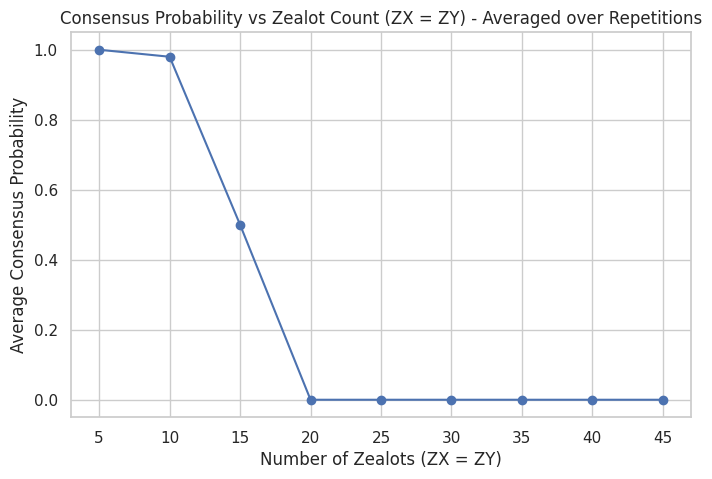

In [ ]:
zealot_range = [5, 10, 15, 20, 25, 30, 35, 40, 45]
results = []
num_repetitions = 5 # Number of repetitions
samples_per_run = 10 # Samples per run
N = 100

print(f"Running {num_repetitions} repetitions with {samples_per_run} samples each for varying zealots.")

for z in zealot_range:
    all_probabilities = []
    initial_state = [40 - z, 40 - z, 20]
    print(f"\n--- Zealot count: ZX = ZY = {z} ---")
    print(f"  Initial state: {initial_state}")
    for rep in range(num_repetitions):
        success = 0
        print(f"  Repetition {rep + 1}/{num_repetitions}")
        for i in range(samples_per_run):
            traj = gillespie_simulation(initial_state, z, z, N)
            satisfied = check_consensus_property(traj, z, z)
            if satisfied:
                success += 1
            # print(f"    Sample {i+1}/{samples_per_run} → {'✔ Consensus' if satisfied else '✘ No consensus'}") # Optional: uncomment to see individual sample results

        probability = success / samples_per_run
        all_probabilities.append(probability)
        print(f"    Consensus Probability for Repetition {rep + 1}: {probability:.3f}")

    average_probability = np.mean(all_probabilities)
    results.append(average_probability)
    print(f"  → Average Consensus probability for {z} zealots over {num_repetitions} repetitions: {average_probability:.3f}")

# Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(zealot_range, results, marker='o')
plt.title("Consensus Probability vs Zealot Count (ZX = ZY) - Averaged over Repetitions")
plt.xlabel("Number of Zealots (ZX = ZY)")
plt.ylabel("Average Consensus Probability")
plt.grid(True)
plt.show()

# Save results as CSV
# Transpose the data for saving as columns: Zealot Count | Average Probability
data_to_save = np.asarray([zealot_range, results]).T
np.savetxt("objective2_internal_averaged.csv", data_to_save, delimiter=",", header="Zealot_Count,Average_Probability", comments="")

## 📈 Objective 3: Varying Group Size N

Running 5 repetitions with 1000 samples each for varying group sizes.


  0%|          | 0/5 [00:00<?, ?it/s]


--- Group Size N = 50 ---
  Zealots: ZX = ZY = 5
  Initial state: X = 20, Y = 20, U = 0
  Repetition 1/5
    Consensus Probability for Repetition 1: 0.000
  Repetition 2/5
    Consensus Probability for Repetition 2: 0.000
  Repetition 3/5
    Consensus Probability for Repetition 3: 0.000
  Repetition 4/5
    Consensus Probability for Repetition 4: 0.000
  Repetition 5/5


 20%|██        | 1/5 [00:31<02:06, 31.69s/it]

    Consensus Probability for Repetition 5: 0.000
  → Average Consensus probability for N=50 over 5 repetitions: 0.000

--- Group Size N = 75 ---
  Zealots: ZX = ZY = 7
  Initial state: X = 30, Y = 30, U = 1
  Repetition 1/5
    Consensus Probability for Repetition 1: 0.728
  Repetition 2/5
    Consensus Probability for Repetition 2: 0.731
  Repetition 3/5
    Consensus Probability for Repetition 3: 0.734
  Repetition 4/5
    Consensus Probability for Repetition 4: 0.730
  Repetition 5/5


 40%|████      | 2/5 [04:24<07:29, 149.83s/it]

    Consensus Probability for Repetition 5: 0.748
  → Average Consensus probability for N=75 over 5 repetitions: 0.734

--- Group Size N = 100 ---
  Zealots: ZX = ZY = 10
  Initial state: X = 40, Y = 40, U = 0
  Repetition 1/5
    Consensus Probability for Repetition 1: 0.992
  Repetition 2/5
    Consensus Probability for Repetition 2: 0.990
  Repetition 3/5
    Consensus Probability for Repetition 3: 0.994
  Repetition 4/5
    Consensus Probability for Repetition 4: 0.992
  Repetition 5/5


 60%|██████    | 3/5 [05:36<03:48, 114.24s/it]

    Consensus Probability for Repetition 5: 0.982
  → Average Consensus probability for N=100 over 5 repetitions: 0.990

--- Group Size N = 125 ---
  Zealots: ZX = ZY = 12
  Initial state: X = 50, Y = 50, U = 1
  Repetition 1/5
    Consensus Probability for Repetition 1: 0.998
  Repetition 2/5
    Consensus Probability for Repetition 2: 0.993
  Repetition 3/5
    Consensus Probability for Repetition 3: 0.994
  Repetition 4/5
    Consensus Probability for Repetition 4: 0.995
  Repetition 5/5


 80%|████████  | 4/5 [07:39<01:57, 117.96s/it]

    Consensus Probability for Repetition 5: 0.999
  → Average Consensus probability for N=125 over 5 repetitions: 0.996

--- Group Size N = 150 ---
  Zealots: ZX = ZY = 15
  Initial state: X = 60, Y = 60, U = 0
  Repetition 1/5
    Consensus Probability for Repetition 1: 0.997
  Repetition 2/5
    Consensus Probability for Repetition 2: 0.996
  Repetition 3/5
    Consensus Probability for Repetition 3: 0.998
  Repetition 4/5
    Consensus Probability for Repetition 4: 0.999
  Repetition 5/5


100%|██████████| 5/5 [10:29<00:00, 125.86s/it]

    Consensus Probability for Repetition 5: 0.997
  → Average Consensus probability for N=150 over 5 repetitions: 0.997


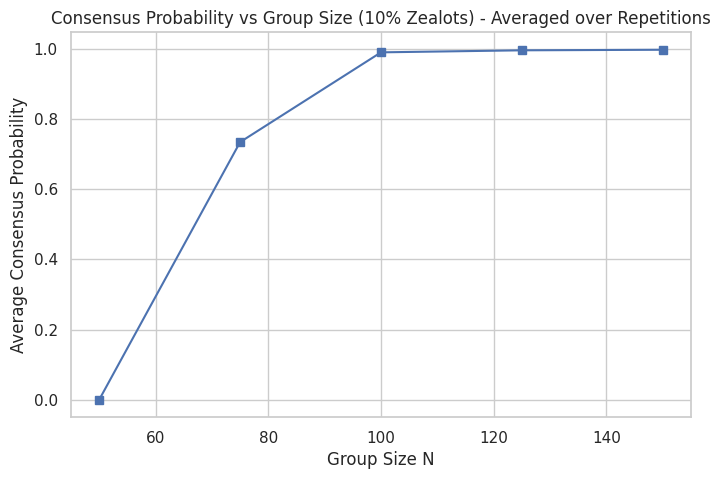

In [ ]:
# vary group size and zealot as a percentage
group_sizes = [50, 75, 100, 125, 150]
zealot_percent = 0.1
num_repetitions = 5 # Number of repetitions
samples_per_run = 1000 # Samples per run
average_probs = []

print(f"Running {num_repetitions} repetitions with {samples_per_run} samples each for varying group sizes.")

for N_val in tqdm(group_sizes):
    zealots = int(zealot_percent * N_val)
    avail = N_val - 2 * zealots
    # Ensure initial state values are non-negative
    X0 = max(0, int(avail * 0.5))
    Y0 = max(0, int(avail * 0.5))
    U0 = max(0, avail - X0 - Y0)
    initial = [X0, Y0, U0]

    all_probabilities = []
    print(f"\n--- Group Size N = {N_val} ---")
    print(f"  Zealots: ZX = ZY = {zealots}")
    print(f"  Initial state: X = {X0}, Y = {Y0}, U = {U0}")

    for rep in range(num_repetitions):
        success = 0
        print(f"  Repetition {rep + 1}/{num_repetitions}")
        for i in range(samples_per_run):
            traj = gillespie_simulation(initial, zealots, zealots, N_val)
            satisfied = check_consensus_property(traj, zealots, zealots)
            if satisfied:
                success += 1
            # print(f"    Sample {i+1}/{samples_per_run} → {'✔ Consensus' if satisfied else '✘ No consensus'}") # Optional: uncomment to see individual sample results

        probability = success / samples_per_run
        all_probabilities.append(probability)
        print(f"    Consensus Probability for Repetition {rep + 1}: {probability:.3f}")

    average_probability = np.mean(all_probabilities)
    average_probs.append(average_probability)
    print(f"  → Average Consensus probability for N={N_val} over {num_repetitions} repetitions: {average_probability:.3f}")


# Plot results
plt.figure(figsize=(8, 5))
plt.plot(group_sizes, average_probs, marker='s')
plt.title("Consensus Probability vs Group Size (10% Zealots) - Averaged over Repetitions")
plt.xlabel("Group Size N")
plt.ylabel("Average Consensus Probability")
plt.grid(True)
plt.show()

# Save results as CSV
data_to_save = np.asarray([group_sizes, average_probs]).T
np.savetxt("objective3_internal_averaged.csv", data_to_save, delimiter=",", header="Group_Size,Average_Probability", comments="")